# Training on Keras Tensorflow

In [1]:
import glob
import librosa
import librosa.display
import numpy as np
import numpy
import _pickle as pickle
from sklearn import svm
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers import Dropout
from keras.utils import plot_model
from IPython.display import SVG
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [5]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
                                              sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


def parse_audio_files(path):
    features, labels = np.empty((0, 193)), np.empty(0)
    labels = []
    for fn in glob.glob(path):
        try:
            mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
        except Exception as e:
            print("Error encountered while parsing file: ", fn)
            continue
        ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
        features = np.vstack([features, ext_features])
        labels = np.append(labels, fn.split("_")[3].split(".")[0])

    return np.array(features), np.array(labels)

In [6]:
tr_features, tr_labels = parse_audio_files('./train_80/*.wav')


tr_features = np.array(tr_features, dtype=pd.Series)
tr_labels = np.array(tr_labels, dtype=pd.Series)

X = tr_features.astype(int)
Y = tr_labels.astype(str)

In [37]:
X.shape, Y.shape

((2239, 193), (2239,))

In [48]:
seed = 7
numpy.random.seed(seed)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

dummy_y = np_utils.to_categorical(encoded_Y)

In [49]:
dummy_y

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [50]:

def baseline_model():
    deep_model = Sequential()
    deep_model.add(Dense(100, input_dim=193, activation="relu", kernel_initializer="uniform"))
    deep_model.add(Dropout(0.5))
    deep_model.add(Dense(50, activation="relu", kernel_initializer="uniform"))
    deep_model.add(Dropout(0.5))
    deep_model.add(Dense(20, activation="relu", kernel_initializer="uniform"))
    deep_model.add(Dropout(0.5))
    deep_model.add(Dense(7, activation="softmax", kernel_initializer="uniform"))

    deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return deep_model


epoches = 100
batch_size = 25
verbose = 1

model = baseline_model()
result = model.fit(X, dummy_y, validation_split=0.1, batch_size=batch_size, epochs=epoches, verbose=verbose)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean() * 100, results.std() * 100))

print(result.history)

filename = 'keras_model.h5'

model.save(filename)

print('Model Saved..')

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 2015 samples, validate on 224 samples
Epoch 1/100
2015/2015 [==============================] - 2s 804us/step - loss: 1.8989 - acc: 0.1876 - val_loss: 1.6764 - val_acc: 0.2857
Epoch 2/100
2015/2015 [==============================] - 0s 214us/step - loss: 1.4462 - acc: 0.3682 - val_loss: 1.2077 - val_acc: 0.5045
Epoch 3/100
2015/2015 [==============================] - 0s 207us/step - loss: 1.1316 - acc: 0.4913 - val_loss: 0.9728 - val_acc: 0.6205
Epoch 4/100
2015/2015 [==============================] - 0s 205us/step - loss: 0.9583 - acc: 0.5856 - val_loss: 0.7012 - val_acc: 0.8393
Epoch 5/100
2015/2015 [==============================] - 0s 211us/step - loss: 0.7906 - acc: 0.6665 - val_loss: 0.5607 - val_acc: 0.8438
Epoch 6/100
2015/2015 [==============================] - 0s 219us/step - loss: 0.7136 - acc: 0.7112 - val_loss: 0.4792 - val_acc: 0.8884
Epoch 7/100
2015/2015 [==============================] - 0s 237us/step - loss: 0.6232 - acc: 0.7395 - val_loss: 0.4232 - val_acc: 0

2015/2015 [==============================] - 0s 236us/step - loss: 0.1807 - acc: 0.9385 - val_loss: 0.1145 - val_acc: 0.9821
Epoch 61/100
2015/2015 [==============================] - 0s 201us/step - loss: 0.2229 - acc: 0.9275 - val_loss: 0.1185 - val_acc: 0.9821
Epoch 62/100
2015/2015 [==============================] - 0s 210us/step - loss: 0.1949 - acc: 0.9325 - val_loss: 0.0698 - val_acc: 0.9821
Epoch 63/100
2015/2015 [==============================] - 0s 230us/step - loss: 0.1963 - acc: 0.9335 - val_loss: 0.0712 - val_acc: 0.9821
Epoch 64/100
2015/2015 [==============================] - 0s 234us/step - loss: 0.2041 - acc: 0.9370 - val_loss: 0.0659 - val_acc: 0.9777
Epoch 65/100
2015/2015 [==============================] - 0s 215us/step - loss: 0.1877 - acc: 0.9370 - val_loss: 0.0626 - val_acc: 0.9866
Epoch 66/100
2015/2015 [==============================] - 0s 208us/step - loss: 0.1694 - acc: 0.9464 - val_loss: 0.0590 - val_acc: 0.9821
Epoch 67/100
2015/2015 [=======================

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               19400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 147       
Total para

{'val_acc': [0.28571428311988711, 0.50446427786456682, 0.6205357185431889, 0.8392857148178986, 0.84375000292701385, 0.88839285740894935, 0.906250003193106, 0.84821427161140106, 0.9598214205886636, 0.94196427480450695, 0.94196428810911514, 0.9598214205886636, 0.9732142782637051, 0.97321428491600925, 0.9598214205886636, 0.968749996806894, 0.9776785661067281, 0.98660713567265446, 0.9732142782637051, 0.97767856637282036, 0.98214284782963135, 0.98214285421584335, 0.98660713567265446, 0.98660713567265446, 0.94642856956592625, 0.97321428491600925, 0.9821428544819355, 0.9821428475635392, 0.98660713567265446, 0.9732142782637051, 0.98214284782963135, 0.97767856637282036, 0.9821428475635392, 0.98214284782963135, 0.9776785661067281, 0.96874999015458996, 0.9910714237817696, 0.9910714237817696, 0.968749996806894, 0.9910714237817696, 0.9776785597205162, 0.96874999015458996, 0.99107142404786175, 0.98214284782963135, 0.9776785597205162, 0.9910714237817696, 0.97767856637282036, 0.98214284782963135, 0.97

Model Saved..


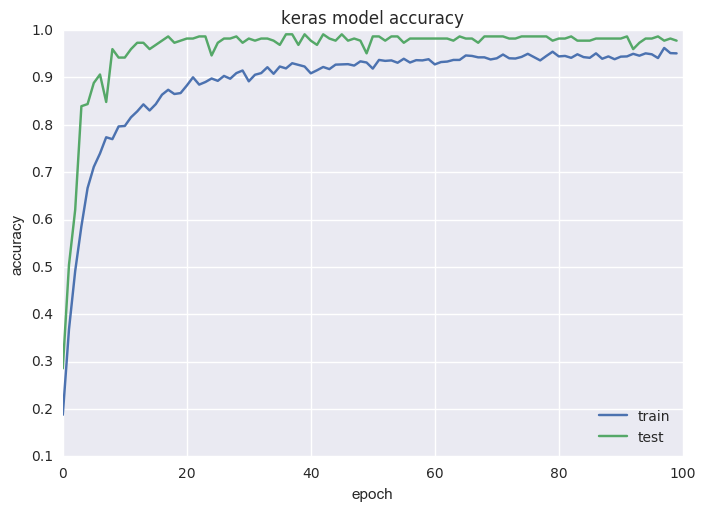

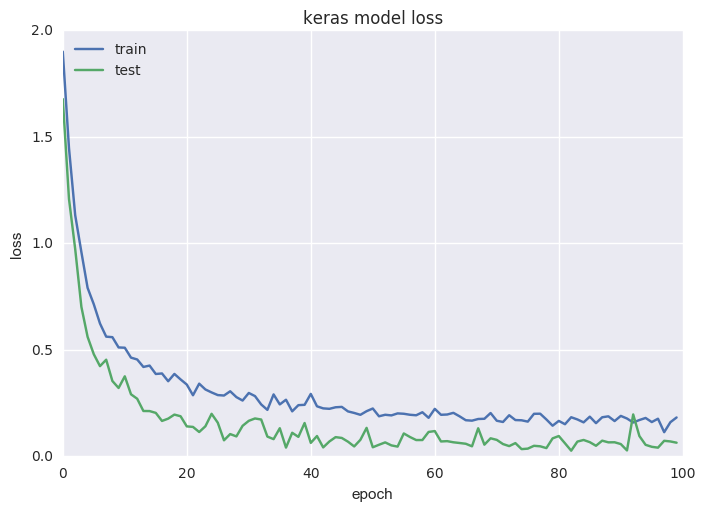

In [77]:
# print("Baseline: %.2f%% (%.2f%%)" % (result.mean() * 100, result.std() * 100))

print(result.history)

filename = 'keras_model_v1.h5'

model.save(filename)

print('Model Saved..')

plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [51]:
result.history.keys()

dict_keys(['val_acc', 'val_loss', 'acc', 'loss'])

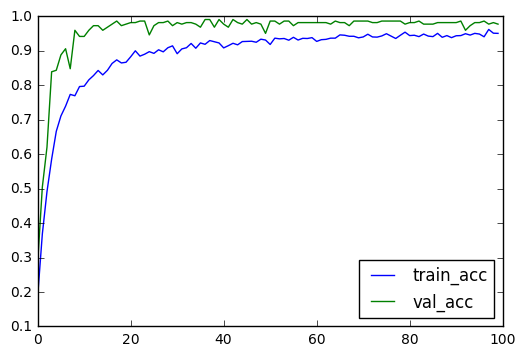

In [58]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

# Testing the model

In [28]:
import glob
import librosa
import librosa.display
import numpy as np
import _pickle as pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [29]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.models import Model

Accuracy Score: 0.996428571429
Number of correct prediction: 558 out of 560


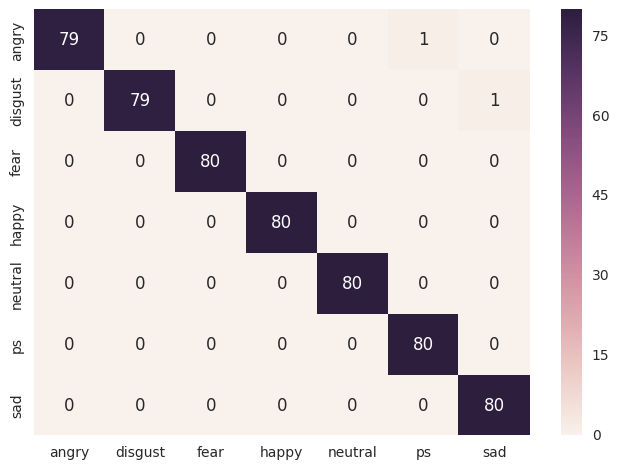

In [63]:
import glob
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.metrics import accuracy_score


def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
                                              sr=sample_rate).T, axis=0)
    return mfccs, chroma, mel, contrast, tonnetz


target_files = []


def parse_audio_files(path):
    labels = []
    features = np.empty((0, 193))
    for fn in glob.glob(path):
        try:
            mfccs, chroma, mel, contrast, tonnetz = extract_feature(fn)
        except Exception as e:
            print("Error encountered while parsing file: ", fn)
            continue
        ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
        features = np.vstack([features, ext_features])
        labels = np.append(labels, fn.split("_")[3].split(".")[0])
        target_files.append(fn)
    return np.array(features), np.array(labels)


ts_features, ts_labels = parse_audio_files('./test_20/*.wav')

ts_features = np.array(ts_features, dtype=pd.Series)
ts_labels = np.array(ts_labels, dtype=pd.Series)

test_true = ts_labels
test_class_label = ts_labels

encoder = LabelEncoder()
encoder.fit(ts_labels.astype(str))
encoded_Y = encoder.transform(ts_labels.astype(str))

ts_labels = np_utils.to_categorical(encoded_Y)

ts_labels.resize(ts_labels.shape[0], 7)

filename = 'keras_model.sav'

model = load_model('keras_model_v1.h5')

prediction = model.predict_classes(ts_features.astype(int))


test_predicted = []

labels_map = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

for i, val in enumerate(prediction):
    test_predicted.append(labels_map[val])

# print(test_predicted)
print("Accuracy Score:", accuracy_score(test_true, test_predicted))
print('Number of correct prediction:', accuracy_score(test_true, test_predicted, normalize=False), 'out of', len(ts_labels))

matrix = confusion_matrix(test_true, test_predicted)
classes = list(set(test_class_label))
classes.sort()
df = pd.DataFrame(matrix, columns=classes, index=classes)
plt.figure()
sn.heatmap(df, annot=True)
plt.show()

In [72]:
file = open("X_train_data_2.txt","w") 
file.write(X) 
file.close() 

TypeError: write() argument must be str, not numpy.ndarray

In [71]:
file1 = open("X_train_data.txt","r") 
file1.read()
file1.close()